In [76]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, callbacks
  
print(tf.version)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# Helper libraries
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import os.path
#import datetime, os

from keras.applications import VGG16, VGG19, ResNet50, InceptionV3, InceptionResNetV2, Xception, MobileNet, DenseNet121, \
    NASNetMobile, EfficientNetB0, MobileNetV2, MobileNetV3Large
from tensorflow.python.keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D
from keras.models import load_model


<module 'tensorflow._api.v2.version' from '/home/jarrad_foley135/miniconda3/envs/mlis_cw_car/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>
Num GPUs Available:  1


In [77]:
batch_size = 16
img_size = [240, 320]

# df = pd.read_csv(r'machine-learning-in-science-ii-2023/training_norm.csv')
# df['filename'] = df["image_id"].astype(str) + ".png"

# df = df.sample(frac=1).reset_index(drop=True)
# print(df)

#df.to_csv("training_norm_shuffle.csv", encoding='utf-8', index=False)

df = pd.read_csv(r'machine-learning-in-science-ii-2023/training_norm_shuffle.csv')
print(df)

x_train = df[0:int(len(df) * 0.1)]
x_validate = df[int(len(df) * 0.6):int(len(df) * 0.8)]
x_evaluate = df[int(len(df) * 0.8):]

# x_train = df[0:int(len(df) * 0.8)]
# x_validate = df[int(len(df) * 0.8):]


       image_id   angle  speed   filename
0           414  0.8125    1.0    414.png
1         17532  0.6875    1.0  17532.png
2         16480  0.3125    0.0  16480.png
3          6450  0.6875    0.0   6450.png
4         12314  0.6250    0.0  12314.png
...         ...     ...    ...        ...
14821      9844  0.6875    1.0   9844.png
14822     12367  0.5000    1.0  12367.png
14823       343  0.9375    1.0    343.png
14824      3838  0.6875    0.0   3838.png
14825     13301  0.5000    1.0  13301.png

[14826 rows x 4 columns]


In [78]:

shift = 0.1

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    fill_mode='nearest',
    # width_shift_range=shift,
    # height_shift_range=shift
)

train_generator = training_datagen.flow_from_dataframe(
    dataframe=x_train,
    directory="machine-learning-in-science-ii-2023/training_data/training_data",
    x_col="filename",
    y_col=["speed"],
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='other')

#print(train_generator)

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_validate,
    directory="machine-learning-in-science-ii-2023/training_data/training_data",
    x_col="filename",
    y_col=["speed"],
    target_size=img_size,
    shuffle=False,
    class_mode='other')

evaluate_datagen = ImageDataGenerator(rescale = 1./255)

eval_generator = evaluate_datagen.flow_from_dataframe(
    dataframe=x_evaluate,
    directory="machine-learning-in-science-ii-2023/training_data/training_data",
    x_col="filename",
    y_col=["speed"],
    target_size=img_size,
    shuffle=False,
    class_mode='other')


Found 8895 validated image filenames.
Found 2965 validated image filenames.
Found 2966 validated image filenames.


In [79]:
shape = (*img_size, 3) # inherited image size with 3 color filters
input_shape = [240, 320, 3]
transfer = MobileNetV2(
    input_shape=input_shape, 
    include_top=False, 
    weights='imagenet',
    classifier_activation="relu"
)

for layer in transfer.layers[:-2]:
    layer.trainable = False

# Speed CNN base
model = models.Sequential()

model.add(transfer)
model.build()
        
model.add(layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu'))
model.add(layers.BatchNormalization())

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())

model.add(layers.Flatten()),

# model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Output layer
model.add(layers.Flatten())
model.add(layers.Dense(1,  activation='sigmoid', kernel_initializer='normal'))

In [ ]:
# Angle CNN base
model_1 = models.Sequential()

model_1.add(transfer)
model_1.build()
        
model.add(layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu'))
model.add(layers.BatchNormalization())

# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())

model_1.add(layers.Flatten()),

# model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dropout(0.2))

# Output layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(1,  activation='relu', kernel_initializer='normal'))

In [80]:
model.build()


In [81]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 10, 1280)      2257984   
 ional)                                                          
                                                                 
 flatten_18 (Flatten)        (None, 102400)            0         
                                                                 
 dense_24 (Dense)            (None, 128)               13107328  
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 128)              

In [82]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data=val_generator,
    callbacks=[es],
    epochs=100
)

Epoch 1/100
556/556 [==============================] - 34s 56ms/step - loss: 0.0354 - val_loss: 0.0271
Epoch 2/100
556/556 [==============================] - 31s 55ms/step - loss: 0.0139 - val_loss: 0.0193
Epoch 3/100
556/556 [==============================] - 31s 55ms/step - loss: 0.0088 - val_loss: 0.0213
Epoch 4/100
556/556 [==============================] - 31s 55ms/step - loss: 0.0061 - val_loss: 0.0175
Epoch 5/100
556/556 [==============================] - 30s 54ms/step - loss: 0.0067 - val_loss: 0.0161
Epoch 6/100
556/556 [==============================] - 30s 54ms/step - loss: 0.0050 - val_loss: 0.0189
Epoch 7/100
556/556 [==============================] - 30s 54ms/step - loss: 0.0038 - val_loss: 0.0174
Epoch 8/100
556/556 [==============================] - 30s 54ms/step - loss: 0.0042 - val_loss: 0.0180
Epoch 9/100
556/556 [==============================] - 31s 55ms/step - loss: 0.0044 - val_loss: 0.0174
Epoch 10/100
556/556 [==============================] - 32s 57ms/step - l

KeyboardInterrupt: 

: 

In [ ]:
model_1.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

history = model_1.fit(
    train_generator,
    batch_size=batch_size,
    validation_data=val_generator,
    callbacks=[es],
    epochs=100
)

In [ ]:
filename = os.listdir("machine-learning-in-science-ii-2023/test_data/test_data") 

df = pd.DataFrame(filename)
df.columns = ["filename"]

df[['file', 'type']] = df.filename.str.split(".", expand = True)
df["file"] = df["file"].astype(str).astype(int)

df.sort_values(by=['file'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(df)


test_datagen = ImageDataGenerator(rescale = 1./255)

test_images = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory="machine-learning-in-science-ii-2023/test_data/test_data",
    x_col="filename",
    target_size=img_size,
    shuffle=False,
    class_mode=None)

print(test_images)

prediction = model.predict(test_images)
print(prediction.shape)
import math

a= prediction[:,0]
b= prediction[:,1]
b+=0.5
b= np.floor(b)

submissiondata={"angle":a , "speed":b} 
df = pd.DataFrame(submissiondata)
df.index += 1 
df.to_csv('Submission.csv')


      filename  file type
0        1.png     1  png
1        2.png     2  png
2        3.png     3  png
3        4.png     4  png
4        5.png     5  png
...        ...   ...  ...
1015  1016.png  1016  png
1016  1017.png  1017  png
1017  1018.png  1018  png
1018  1019.png  1019  png
1019  1020.png  1020  png

[1020 rows x 3 columns]
Found 1020 validated image filenames.
32/32 [==============================] - 4s 99ms/step
(1020, 1)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
from sklearn.metrics import classification_report

test_loss = model.evaluate(
    eval_generator,
    verbose=1
)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=x_evaluate,
    directory="machine-learning-in-science-ii-2023/training_data/training_data",
    x_col="filename",
    target_size=img_size,
    shuffle=False,
    class_mode=None)


prediction = model.predict(test_generator, verbose =1)

a= prediction[:,0]
b= prediction[:,1]
b+=0.5
b= np.floor(b)

submissiondata={"angle":a , "speed":b} 
df = pd.DataFrame(submissiondata)
df.index += 1 
df.to_csv('evaluate.csv')



93/93 [==============================] - 8s 86ms/step - loss: 0.0064
Found 2966 validated image filenames.
93/93 [==============================] - 6s 68ms/step


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
diff = abs(x_evaluate["angle"] - a)

results = pd.DataFrame({"Train":x_evaluate["angle"], "Predicted":a, "Difference":diff})
#results

#results.to_csv('evaluate.csv')

In [ ]:
results = pd.DataFrame({"Train":x_evaluate["speed"],"Predicted":b})
#results

#results.to_csv('evaluate.csv')

In [ ]:
model.save("speed-model.h5")
model_1.save("angle-model.h5")


In [ ]:
model_architecture = model.to_json()
model.save_weights("model_weights.h5")

In [ ]:
from tensorflow.keras.models import model_from_json
# model2 = model_from_json(model_architecture)
# model2.load_weights("model_weights.h5")


model2 = load_model('model.hdf5')

transfer = model2.layers[0]
transfer.trainable = True


for layer in transfer.layers[:-25]:
    layer.trainable = False

#model2.trainable = True

# for layer in model2.layers[:2]:
#     layer.trainable = False
    
model2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 10, 1280)      2257984   
 ional)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 8, 128)         1474688   
                                                                 
 batch_normalization_10 (Bat  (None, 6, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 6, 128)         147584    
                                                                 
 batch_normalization_11 (Bat  (None, 4, 6, 128)        512       
 chNormalization)                                                
                                                      

In [ ]:

model2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.00001), # 1e-5 
    loss='mean_squared_error'
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005,
    patience=30,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model2.fit(
    train_generator,
    batch_size=batch_size,
    validation_data=val_generator,
    callbacks=[es],
    epochs=300
)


Epoch 1/300
556/556 [==============================] - 34s 50ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 2/300
556/556 [==============================] - 26s 47ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 3/300
556/556 [==============================] - 27s 49ms/step - loss: 0.0066 - val_loss: 0.0102
Epoch 4/300
556/556 [==============================] - 27s 49ms/step - loss: 0.0060 - val_loss: 0.0105
Epoch 5/300
556/556 [==============================] - 26s 47ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 6/300
556/556 [==============================] - 26s 47ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 7/300
556/556 [==============================] - 26s 47ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 8/300
556/556 [==============================] - 27s 49ms/step - loss: 0.0049 - val_loss: 0.0105
Epoch 9/300
556/556 [==============================] - 26s 46ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 10/300
556/556 [==============================] - 27s 48ms/step - l

In [ ]:
from sklearn.metrics import classification_report

test_loss = model2.evaluate(
    eval_generator,
    verbose=1
)


93/93 [==============================] - 8s 86ms/step - loss: 0.0110


In [ ]:
model2.save("model-fine-tuning.hdf5")

In [ ]:

prediction = model2.predict(test_images)
print(prediction.shape)
import math

a= prediction[:,0]
b= prediction[:,1]
b+=0.5
b= np.floor(b)

submissiondata={"angle":a , "speed":b} 
df = pd.DataFrame(submissiondata)
df.index += 1 
df.to_csv('Submission-fine-tuning.csv')


32/32 [==============================] - 4s 91ms/step
(1020, 2)


In [ ]:
from keras.utils.vis_utils import plot_model

model = load_model("model-fine-tuning.hdf5")

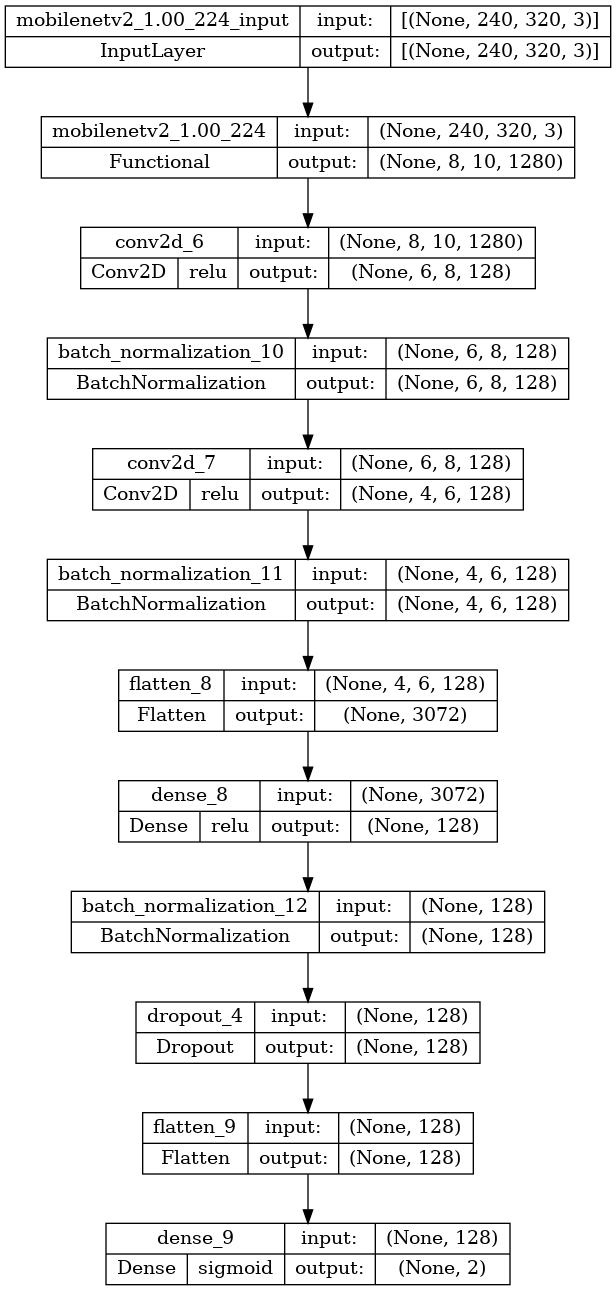

In [ ]:
plot_model(model, show_layer_names=True, show_shapes=True,show_layer_activations=True)

In [ ]:
pip install pydot

/bin/bash: /home/jarrad_foley135/miniconda3/envs/mlis_cw_car/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
plot_model(model, show_layer_names=True, show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
